2025-05-29 09:47:50.161252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748512070.180897   68160 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748512070.186917   68160 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748512070.201793   68160 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748512070.201811   68160 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748512070.201813   68160 computation_placer.cc:177] computation placer alr

--- Case 1: Chirped Grating ---
Chirped Grating - Elapsed time: 1.30 seconds
Chirped Grating Score: 0.040606
Chirped Grating Centroid: 0.9986 µm

--- Case 2: 7.2 Period Grating ---
7.2 Period Grating - Elapsed time: 0.36 seconds
7.2 Period Grating Score: 0.000339
7.2 Period Grating Centroid: 1.0271 µm


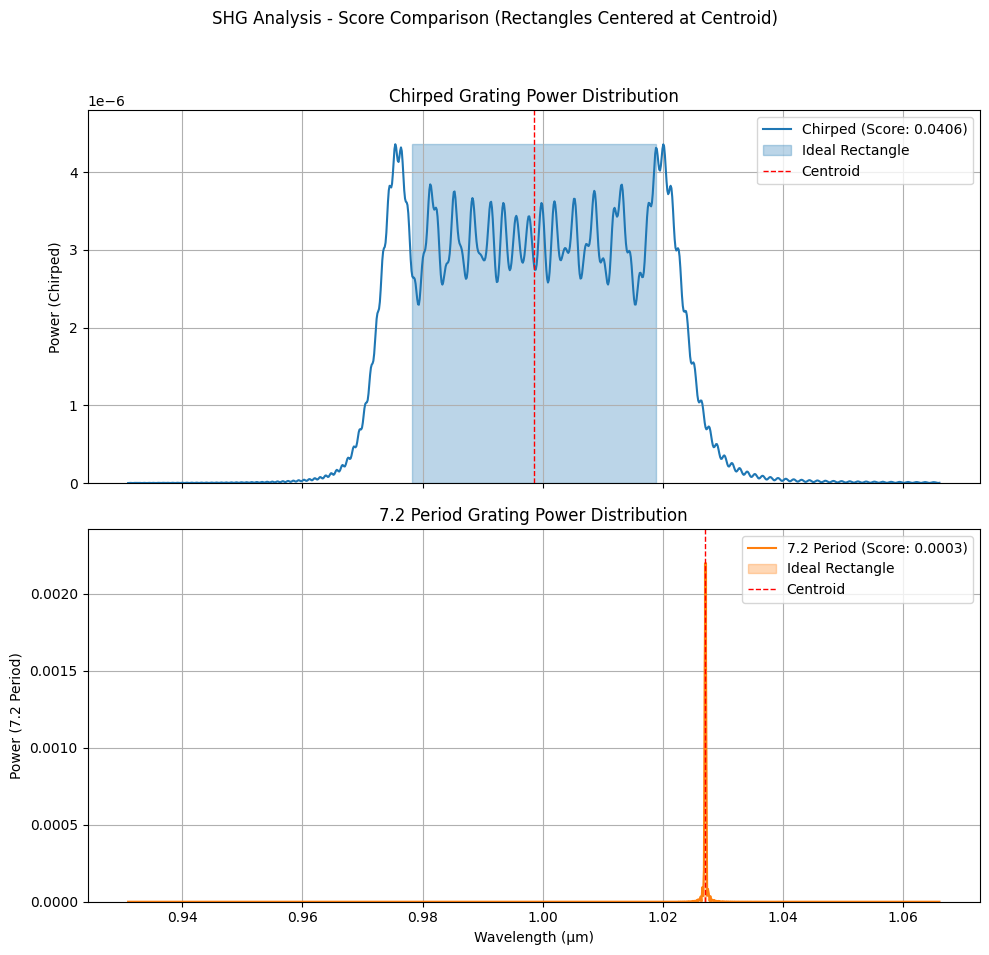

In [2]:
import jax.numpy as jnp
import timeit
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp
from typing import List
import numpy as np


# ---------------------------------------------------------------------------
# 広帯域スコア計算関数
# ---------------------------------------------------------------------------
def calculate_broadband_score(wavelengths, power):
    wavelengths_jnp = jnp.array(wavelengths)
    power_jnp = jnp.array(power)
    if power_jnp.size == 0 or wavelengths_jnp.size != power_jnp.size:
        return jnp.array(0.0)
    peak_power = jnp.max(power_jnp)

    def calculate():
        total_area = jnp.trapezoid(power_jnp, wavelengths_jnp)
        return total_area / peak_power
    return jnp.where(peak_power <= 0, jnp.array(0.0), calculate())


# ---------------------------------------------------------------------------
# 重心計算関数
# ---------------------------------------------------------------------------
def calculate_centroid(wavelengths, power):
    """スペクトルの重心（Centroid）を計算します。"""
    wavelengths_jnp = jnp.array(wavelengths)
    power_jnp = jnp.array(power)

    peak_power = jnp.max(power_jnp)
    if peak_power <= 0:
        return jnp.mean(wavelengths_jnp)  # パワーがない場合は中央値を返す

    total_area = jnp.trapezoid(power_jnp, wavelengths_jnp)
    weighted_area = jnp.trapezoid(power_jnp * wavelengths_jnp, wavelengths_jnp)

    return weighted_area / total_area


# ---------------------------------------------------------------------------
# シミュレーション設定
# ---------------------------------------------------------------------------
num_domains = 1000
domain_width = 1.031E-05
wavelengths_list = jnp.linspace(0.931, 1.066, 1000).tolist()
wavelengths_jnp = jnp.array(wavelengths_list)
T_dim: List[float] = [20, 70]
temp_idx_to_use = 0
fund_idx_to_use = 0

# ---------------------------------------------------------------------------
# Case 1: Chirped Grating の計算
# ---------------------------------------------------------------------------
print("--- Case 1: Chirped Grating ---")
grating_chirped = pp.chirped(600, [3.6], domain_width, [0.0001])
params_chirped = shg.Params(grating_dim=grating_chirped, T_dim=T_dim,
                            wavelength_dim=wavelengths_list, fund_power_dim=1, sh_power_dim=0)
start = timeit.default_timer()
eff_tensor_chirped = mgoslt.analyze(params_chirped)
stop = timeit.default_timer()
print(f"Chirped Grating - Elapsed time: {stop - start:.2f} seconds")
eff_complex_chirped = eff_tensor_chirped[temp_idx_to_use,
                                         fund_idx_to_use, :, 0, 0]
power_chirped = jnp.abs(eff_complex_chirped)**2
score_chirped = calculate_broadband_score(wavelengths_jnp, power_chirped)
centroid_chirped = calculate_centroid(wavelengths_jnp, power_chirped)  # 重心を計算
print(f"Chirped Grating Score: {score_chirped:.6f}")
print(f"Chirped Grating Centroid: {centroid_chirped:.4f} µm")

# ---------------------------------------------------------------------------
# Case 2: 7.2 Period Grating の計算
# ---------------------------------------------------------------------------
print("\n--- Case 2: 7.2 Period Grating ---")
grating_7_2 = pp.periodical(num_domains * 2, [7.2], domain_width, 1/2)
params_7_2 = shg.Params(grating_dim=grating_7_2, T_dim=T_dim,
                        wavelength_dim=wavelengths_list, fund_power_dim=1, sh_power_dim=0)
start = timeit.default_timer()
eff_tensor_7_2 = mgoslt.analyze(params_7_2)
stop = timeit.default_timer()
print(f"7.2 Period Grating - Elapsed time: {stop - start:.2f} seconds")
eff_complex_7_2 = eff_tensor_7_2[temp_idx_to_use, fund_idx_to_use, :, 0, 0]
power_7_2 = jnp.abs(eff_complex_7_2)**2
score_7_2 = calculate_broadband_score(wavelengths_jnp, power_7_2)
centroid_7_2 = calculate_centroid(wavelengths_jnp, power_7_2)  # 重心を計算
print(f"7.2 Period Grating Score: {score_7_2:.6f}")
print(f"7.2 Period Grating Centroid: {centroid_7_2:.4f} µm")

# ---------------------------------------------------------------------------
# 結果のプロット (別々のグラフ + 重心中心の理想矩形)
# ---------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
fig.suptitle(
    "SHG Analysis - Score Comparison (Rectangles Centered at Centroid)")

# --- Plot 1: Chirped Grating ---
p_max_chirped = jnp.max(power_chirped)
rect_start_chirped = centroid_chirped - (score_chirped / 2)  # 左端 = 重心 - 幅/2

ax1.plot(wavelengths_list, power_chirped,
         label=f"Chirped (Score: {score_chirped:.4f})", color='tab:blue')
rect1 = plt.Rectangle((float(rect_start_chirped), 0), float(score_chirped), float(p_max_chirped),  # type: ignore
                      color='tab:blue', alpha=0.3, label='Ideal Rectangle')
ax1.add_patch(rect1)
ax1.axvline(x=float(centroid_chirped), color='red', linestyle='--',
            linewidth=1, label='Centroid')  # 重心線を追加
ax1.set_ylabel("Power (Chirped)")
ax1.set_title("Chirped Grating Power Distribution")
ax1.legend()
ax1.grid(True)
ax1.set_ylim(0, float(p_max_chirped) * 1.1 if p_max_chirped > 0 else 1)

# --- Plot 2: 7.2 Period Grating ---
p_max_7_2 = jnp.max(power_7_2)
rect_start_7_2 = centroid_7_2 - (score_7_2 / 2)  # 左端 = 重心 - 幅/2

ax2.plot(wavelengths_list, power_7_2,
         label=f"7.2 Period (Score: {score_7_2:.4f})", color='tab:orange')
rect2 = plt.Rectangle((float(rect_start_7_2), 0), float(score_7_2), float(p_max_7_2),  # type: ignore
                      color='tab:orange', alpha=0.3, label='Ideal Rectangle')
ax2.add_patch(rect2)
ax2.axvline(x=float(centroid_7_2), color='red', linestyle='--',
            linewidth=1, label='Centroid')  # 重心線を追加
ax2.set_xlabel("Wavelength (μm)")
ax2.set_ylabel("Power (7.2 Period)")
ax2.set_title("7.2 Period Grating Power Distribution")
ax2.legend()
ax2.grid(True)
ax2.set_ylim(0, float(p_max_7_2) * 1.1 if p_max_7_2 > 0 else 1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # type: ignore
plt.show()


# TODO: ここから下の指示にしたがった実装
# TODO: 周期分極反転構造を5つ連結した構造において、もっとも分布がフラットになる条件をオプティマイザで求める
# 以下のduties5つとperiod5つ、合計10個がオプティマイザで求めるパラメータ
duties = [1/2, 1/3, 1/4, 1/5, 1/6]
period = [7.2, 8.0, 9.0, 10.0, 11.0]
gratings = [pp.periodical(num_domains * 2, [p], domain_width, d)
            for d, p in zip(duties, period)]

In [3]:
from scipy.optimize import minimize
import timeit
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp  # 念のためインポート

# ---------------------------------------------------------------------------
# 最適化のための設定
# ---------------------------------------------------------------------------
num_segments = 5      # 連結する構造の数
num_domains_per_segment = 1000

T_dim_opt: List[float] = [20.0]  # 最適化中は温度を1点に固定
temp_idx_to_use = 0
fund_idx_to_use = 0

# ---------------------------------------------------------------------------
# 計算: 7.2 µm 周期グレーティング (Plot 1用)
# ---------------------------------------------------------------------------
print("\n--- Calculating 7.2 Period State ---")
# 周期7.2µm, Duty 0.5 の単純な周期的構造を生成
# 全体のドメイン数は最適化対象と合わせる
total_domains = num_segments * num_domains_per_segment
grating_7_2 = pp.periodical(total_domains, [7.2], domain_width, 0.5)
params_7_2 = shg.Params(grating_dim=grating_7_2, T_dim=T_dim_opt,
                        wavelength_dim=wavelengths_list, fund_power_dim=1, sh_power_dim=0)
eff_tensor_7_2 = mgoslt.analyze(params_7_2)
eff_complex_7_2 = eff_tensor_7_2[temp_idx_to_use, fund_idx_to_use, :, 0, 0]
power_7_2 = jnp.abs(eff_complex_7_2)**2
score_7_2 = calculate_broadband_score(wavelengths_jnp, power_7_2)
centroid_7_2 = calculate_centroid(wavelengths_jnp, power_7_2)
print(f"7.2 Period Score: {score_7_2:.6f}")
print(f"7.2 Period Centroid: {centroid_7_2:.4f} µm")


# ---------------------------------------------------------------------------
# 計算: 最適化前の初期状態 (Plot 2用)
# ---------------------------------------------------------------------------
print("\n--- Calculating Initial State ---")
initial_duties = [1/2, 1/3, 1/4, 1/5, 1/6]
initial_periods = [7.2, 8.0, 9.0, 10.0, 11.0]
initial_gratings = [
    pp.periodical(num_domains_per_segment, [p], domain_width, d)
    for d, p in zip(initial_duties, initial_periods)
]
grating_initial = pp.concatenate(initial_gratings)
params_initial = shg.Params(grating_dim=grating_initial, T_dim=T_dim_opt,
                            wavelength_dim=wavelengths_list, fund_power_dim=1, sh_power_dim=0)
eff_tensor_initial = mgoslt.analyze(params_initial)
eff_complex_initial = eff_tensor_initial[temp_idx_to_use,
                                         fund_idx_to_use, :, 0, 0]
power_initial = jnp.abs(eff_complex_initial)**2
score_initial = calculate_broadband_score(wavelengths_jnp, power_initial)
centroid_initial = calculate_centroid(wavelengths_jnp, power_initial)
print(f"Initial State Score: {score_initial:.6f}")
print(f"Initial State Centroid: {centroid_initial:.4f} µm")


# ---------------------------------------------------------------------------
# 最適化のための目的関数
# ---------------------------------------------------------------------------
def objective_function(params_array):
    """
    与えられたパラメータ (duties, periods) で構造を生成し、
    SHGシミュレーションを行い、広帯域スコアの負の値を返す。
    """
    duties = params_array[:num_segments]
    periods = params_array[num_segments:]

    try:
        gratings = [
            pp.periodical(num_domains_per_segment, [p], domain_width, d)
            for d, p in zip(duties, periods)
        ]
        concatenated_grating = pp.concatenate(gratings)

        shg_params = shg.Params(
            grating_dim=concatenated_grating,
            T_dim=T_dim_opt,
            wavelength_dim=wavelengths_list,
            fund_power_dim=1,
            sh_power_dim=0
        )
        eff_tensor = mgoslt.analyze(shg_params)
        eff_complex = eff_tensor[temp_idx_to_use, fund_idx_to_use, :, 0, 0]
        power = jnp.abs(eff_complex)**2
        score = calculate_broadband_score(wavelengths_jnp, power)

        objective_value = -float(score)
        print(
            f"Params: {[f'{x:.3f}' for x in params_array]} -> Score: {-objective_value:.6f}")
        return objective_value
    except Exception as e:
        print(f"Error for params {params_array}: {e}")
        return 1.0  # ペナルティ


# ---------------------------------------------------------------------------
# 最適化の実行
# ---------------------------------------------------------------------------
print("\n--- Running Optimization ---")
x0 = np.array(initial_duties + initial_periods)

bounds = ([(0.1, 0.9)] * num_segments +
          [(5.0, 15.0)] * num_segments)

start_opt = timeit.default_timer()
result = minimize(
    objective_function,
    x0,
    bounds=bounds,
    # options={'disp': True} # 詳細なログが必要な場合
)
stop_opt = timeit.default_timer()

print(
    f"\nOptimization Finished - Elapsed time: {stop_opt - start_opt:.2f} seconds")

# ---------------------------------------------------------------------------
# 最適化結果の表示と計算
# ---------------------------------------------------------------------------
if result.success:
    optimal_params = result.x
    optimal_duties = optimal_params[:num_segments]
    optimal_periods = optimal_params[num_segments:]

    print("\nOptimal Parameters Found:")
    print(f"  Duties: {[f'{d:.4f}' for d in optimal_duties]}")
    print(f"  Periods: {[f'{p:.4f}' for p in optimal_periods]}")
    print(f"Optimal Score (Max Broadband Score): {-result.fun:.6f}")

    optimal_gratings = [
        pp.periodical(num_domains_per_segment, [p], domain_width, d)
        for d, p in zip(optimal_duties, optimal_periods)
    ]
    grating_optimized = pp.concatenate(optimal_gratings)
    params_optimized = shg.Params(grating_dim=grating_optimized, T_dim=T_dim_opt,
                                  wavelength_dim=wavelengths_list, fund_power_dim=1, sh_power_dim=0)
    eff_tensor_optimized = mgoslt.analyze(params_optimized)
    eff_complex_optimized = eff_tensor_optimized[temp_idx_to_use,
                                                 fund_idx_to_use, :, 0, 0]
    power_optimized = jnp.abs(eff_complex_optimized)**2
    score_optimized = calculate_broadband_score(
        wavelengths_jnp, power_optimized)
    centroid_optimized = calculate_centroid(wavelengths_jnp, power_optimized)
    print(
        f"Optimized Grating Score (Recalculated @ {T_dim_opt[temp_idx_to_use]} C): {score_optimized:.6f}")
    print(f"Optimized Grating Centroid: {centroid_optimized:.4f} µm")

else:
    print("\nOptimization failed or did not converge.")
    print(f"Message: {result.message}")
    power_optimized = jnp.zeros_like(wavelengths_jnp)
    score_optimized = jnp.array(0.0)
    centroid_optimized = jnp.mean(wavelengths_jnp)

# ---------------------------------------------------------------------------
# 結果のプロット (変更)
# ---------------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
fig.suptitle(
    "SHG Analysis - Score Comparison (Rectangles Centered at Centroid)")

# --- Plot 1: 7.2 Period Grating ---
p_max_7_2 = jnp.max(power_7_2)
rect_start_7_2 = centroid_7_2 - (score_7_2 / 2)
ax1.plot(wavelengths_list, power_7_2,
         label=f"7.2 Period (Score: {score_7_2:.4f})", color='tab:orange')
if p_max_7_2 > 0:
    rect1 = plt.Rectangle((float(rect_start_7_2), 0), float(score_7_2), float(p_max_7_2),
                          color='tab:orange', alpha=0.3, label='Ideal Rectangle')
    ax1.add_patch(rect1)
ax1.axvline(x=float(centroid_7_2), color='red',
            linestyle='--', linewidth=1, label='Centroid')
ax1.set_ylabel("Power (7.2 Period)")
ax1.set_title("7.2 Period Grating Power Distribution")
ax1.legend()
ax1.grid(True)
ax1.set_ylim(0, float(p_max_7_2) * 1.1 if p_max_7_2 > 0 else 1)

# --- Plot 2: Initial State Grating ---
p_max_initial = jnp.max(power_initial)
rect_start_initial = centroid_initial - (score_initial / 2)
ax2.plot(wavelengths_list, power_initial,
         label=f"Initial (Score: {score_initial:.4f})", color='tab:blue')
if p_max_initial > 0:
    rect2 = plt.Rectangle((float(rect_start_initial), 0), float(score_initial), float(p_max_initial),
                          color='tab:blue', alpha=0.3, label='Ideal Rectangle')
    ax2.add_patch(rect2)
ax2.axvline(x=float(centroid_initial), color='red',
            linestyle='--', linewidth=1, label='Centroid')
ax2.set_ylabel("Power (Initial)")
ax2.set_title("Initial Grating Power Distribution")
ax2.legend()
ax2.grid(True)
ax2.set_ylim(0, float(p_max_initial) * 1.1 if p_max_initial > 0 else 1)

# --- Plot 3: Optimized Grating ---
p_max_optimized = jnp.max(power_optimized)
rect_start_optimized = centroid_optimized - (score_optimized / 2)
ax3.plot(wavelengths_list, power_optimized,
         label=f"Optimized (Score: {score_optimized:.4f})", color='tab:green')
if score_optimized > 0 and p_max_optimized > 0:
    rect3 = plt.Rectangle((float(rect_start_optimized), 0), float(score_optimized), float(p_max_optimized),
                          color='tab:green', alpha=0.3, label='Ideal Rectangle')
    ax3.add_patch(rect3)
ax3.axvline(x=float(centroid_optimized), color='red',
            linestyle='--', linewidth=1, label='Centroid')
ax3.set_xlabel("Wavelength (μm)")
ax3.set_ylabel("Power (Optimized)")
ax3.set_title("Optimized Grating Power Distribution")
ax3.legend()
ax3.grid(True)
ax3.set_ylim(0, float(p_max_optimized) * 1.1 if p_max_optimized > 0 else 1)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Calculating 7.2 Period State ---
7.2 Period Score: 0.000203
7.2 Period Centroid: 1.0271 µm

--- Calculating Initial State ---
Initial State Score: 0.001435
Initial State Centroid: 1.0357 µm

--- Running Optimization ---
Params: ['0.500', '0.333', '0.250', '0.200', '0.167', '7.200', '8.000', '9.000', '10.000', '11.000'] -> Score: 0.001435
Params: ['0.500', '0.333', '0.250', '0.200', '0.167', '7.200', '8.000', '9.000', '10.000', '11.000'] -> Score: 0.001435
Params: ['0.500', '0.333', '0.250', '0.200', '0.167', '7.200', '8.000', '9.000', '10.000', '11.000'] -> Score: 0.001435
Params: ['0.500', '0.333', '0.250', '0.200', '0.167', '7.200', '8.000', '9.000', '10.000', '11.000'] -> Score: 0.001435
Params: ['0.500', '0.333', '0.250', '0.200', '0.167', '7.200', '8.000', '9.000', '10.000', '11.000'] -> Score: 0.001435
Params: ['0.500', '0.333', '0.250', '0.200', '0.167', '7.200', '8.000', '9.000', '10.000', '11.000'] -> Score: 0.001435
Params: ['0.500', '0.333', '0.250', '0.200', '0.167', '

KeyboardInterrupt: 

Fixed Periods: [7.2, 7.2, 7.2, 7.2, 7.2]
Wavelength Range: 1.024 - 1.030 µm
Score Scaling Factor: 10000000.0

--- Running Duty Ratio Optimization ---
Duties: ['0.100', '0.100', '0.100', '0.100', '0.100'] -> Orig Score: 0.00132909 -> Scaled Score: 13290.863281
Duties: ['0.105', '0.100', '0.100', '0.100', '0.100'] -> Orig Score: 0.00135478 -> Scaled Score: 13547.769531
Duties: ['0.100', '0.105', '0.100', '0.100', '0.100'] -> Orig Score: 0.00135088 -> Scaled Score: 13508.839844
Duties: ['0.100', '0.100', '0.105', '0.100', '0.100'] -> Orig Score: 0.00135600 -> Scaled Score: 13560.002930
Duties: ['0.100', '0.100', '0.100', '0.105', '0.100'] -> Orig Score: 0.00135484 -> Scaled Score: 13548.436523
Duties: ['0.100', '0.100', '0.100', '0.100', '0.105'] -> Orig Score: 0.00135718 -> Scaled Score: 13571.849609
Duties: ['0.102', '0.102', '0.102', '0.102', '0.102'] -> Orig Score: 0.00138354 -> Scaled Score: 13835.445312
Duties: ['0.103', '0.103', '0.103', '0.103', '0.103'] -> Orig Score: 0.00138476 

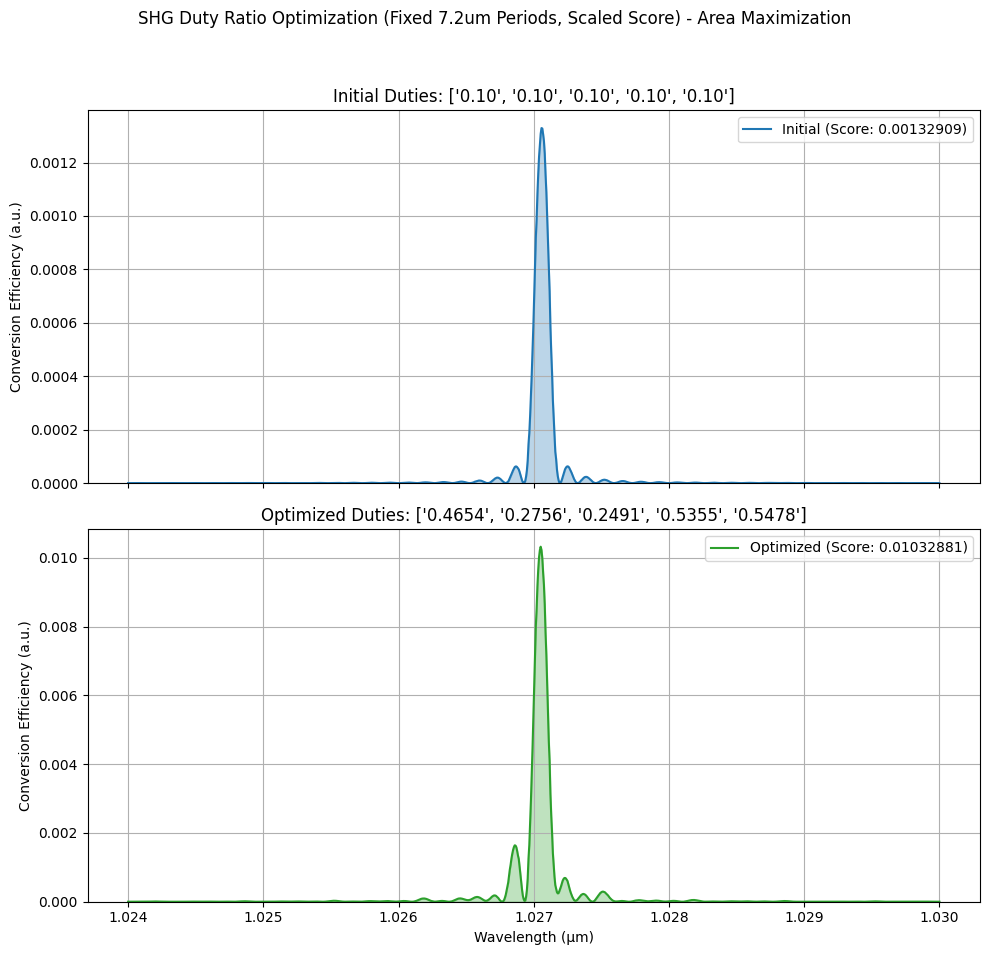

In [17]:
wavelengths_list = np.linspace(1.024, 1.03, 1000).tolist()
wavelengths_jnp = jnp.array(wavelengths_list)


def calculate_area_score(wavelengths, power):
    """変換効率の面積（積分値）を計算"""
    return jnp.trapezoid(power, wavelengths)  # <--- 変更点 (trapz -> trapezoid)


def calculate_peak_score(power):
    """変換効率の最大値を計算"""
    return jnp.max(power)  # <--- 変更点 (jnp.max を使用)


# ---------------------------------------------------------------------------
# 最適化のための設定
# ---------------------------------------------------------------------------
num_segments = 5
num_domains_per_segment = 1000
T_dim_opt: List[float] = [20.0]
temp_idx_to_use = 0
fund_idx_to_use = 0
fixed_periods = [7.2, 7.2, 7.2, 7.2, 7.2]
print(f"Fixed Periods: {fixed_periods}")
# 桁数変更
print(
    f"Wavelength Range: {wavelengths_list[0]:.3f} - {wavelengths_list[-1]:.3f} µm")

# スケーリング係数 # <--- 追加点
scaling_factor = 1e7
print(f"Score Scaling Factor: {scaling_factor}")


# ---------------------------------------------------------------------------
# 最適化のための目的関数 (スケーリング追加)
# ---------------------------------------------------------------------------
def objective_function_duty(duties_array):
    """
    スコアをスケーリングして返す。
    """
    duties = duties_array
    periods = fixed_periods

    try:
        gratings = [
            pp.periodical(num_domains_per_segment, [p], domain_width, d)
            for d, p in zip(duties, periods)
        ]
        concatenated_grating = pp.concatenate(gratings)

        shg_params = shg.Params(
            grating_dim=concatenated_grating,
            T_dim=T_dim_opt,
            wavelength_dim=wavelengths_list,
            fund_power_dim=1,
            sh_power_dim=0
        )
        eff_tensor = mgoslt.analyze(shg_params)
        eff_complex = eff_tensor[temp_idx_to_use, fund_idx_to_use, :, 0, 0]
        power = jnp.abs(eff_complex)**2
        score = calculate_peak_score(power)

        scaled_score = score * scaling_factor  # <--- スケーリング
        objective_value = -float(scaled_score)
        # Print文では元のスコアとスケール後のスコア両方出すと分かりやすいかも
        print(
            f"Duties: {[f'{d:.3f}' for d in duties]} -> Orig Score: {score:.8f} -> Scaled Score: {-objective_value:.6f}")
        return objective_value
    except Exception as e:
        print(f"Error for duties {duties}: {e}")
        # ペナルティもスケールに合わせて大きくするか、あるいは絶対値で返す
        return 1.0 * scaling_factor


# ---------------------------------------------------------------------------
# 最適化の実行 (ftol を少し小さくしてみるオプションも)
# ---------------------------------------------------------------------------
print("\n--- Running Duty Ratio Optimization ---")
initial_duties = [0.1] * num_segments
x0 = np.array(initial_duties)
bounds = [(0.1, 0.9)] * num_segments

start_opt = timeit.default_timer()
result = minimize(
    objective_function_duty,
    x0,
    method="Nelder-Mead",
    bounds=bounds,
)
stop_opt = timeit.default_timer()
print(
    f"\nOptimization Finished - Elapsed time: {stop_opt - start_opt:.2f} seconds")

# ---------------------------------------------------------------------------
# 最適化結果の表示と計算
# ---------------------------------------------------------------------------

# --- 最適化前の初期状態を計算 ---
initial_gratings = [
    pp.periodical(num_domains_per_segment, [p], domain_width, d)
    for d, p in zip(initial_duties, fixed_periods)
]
grating_initial = pp.concatenate(initial_gratings)
params_initial = shg.Params(grating_dim=grating_initial, T_dim=T_dim_opt,
                            wavelength_dim=wavelengths_list, fund_power_dim=1, sh_power_dim=0)
eff_tensor_initial = mgoslt.analyze(params_initial)
eff_complex_initial = eff_tensor_initial[temp_idx_to_use,
                                         fund_idx_to_use, :, 0, 0]
power_initial = jnp.abs(eff_complex_initial)**2
score_initial = calculate_peak_score(power_initial)
print(f"\nInitial State Score (Unscaled): {score_initial:.8f}")


# --- 最適化後の状態を計算 ---
if result.success:
    optimal_duties = result.x
    print("\nOptimal Duties Found:")
    print(f"  Duties: {[f'{d:.4f}' for d in optimal_duties]}")
    # result.fun はスケール後の値なので、元のスケールに戻して表示
    print(f"Optimal Score (Unscaled): {-result.fun / scaling_factor:.8f}")

    optimal_gratings = [
        pp.periodical(num_domains_per_segment, [p], domain_width, d)
        for d, p in zip(optimal_duties, fixed_periods)
    ]
    grating_optimized = pp.concatenate(optimal_gratings)
    params_optimized = shg.Params(grating_dim=grating_optimized, T_dim=T_dim_opt,
                                  wavelength_dim=wavelengths_list, fund_power_dim=1, sh_power_dim=0)
    eff_tensor_optimized = mgoslt.analyze(params_optimized)
    eff_complex_optimized = eff_tensor_optimized[temp_idx_to_use,
                                                 fund_idx_to_use, :, 0, 0]
    power_optimized = jnp.abs(eff_complex_optimized)**2
    score_optimized = calculate_peak_score(power_optimized)
    print(
        f"Optimized Grating Score (Recalculated, Unscaled): {score_optimized:.8f}")

else:
    print("\nOptimization failed or did not converge.")
    print(f"Message: {result.message}")
    optimal_duties = initial_duties
    power_optimized = power_initial
    score_optimized = score_initial  # score_optimized を初期値に設定

# ---------------------------------------------------------------------------
# 結果のプロット (スコア表示をUnscaledに)
# ---------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
fig.suptitle(
    "SHG Duty Ratio Optimization (Fixed 7.2um Periods, Scaled Score) - Area Maximization")

# --- Plot 1: Initial State ---
ax1.plot(wavelengths_list, power_initial,
         # Unscaled 表示
         label=f"Initial (Score: {score_initial:.8f})", color='tab:blue')
ax1.fill_between(wavelengths_list, power_initial, color='tab:blue', alpha=0.3)
ax1.set_ylabel("Conversion Efficiency (a.u.)")
ax1.set_title(f"Initial Duties: {[f'{d:.2f}' for d in initial_duties]}")
ax1.legend()
ax1.grid(True)
ax1.set_ylim(bottom=0)

# --- Plot 2: Optimized State ---
ax2.plot(wavelengths_list, power_optimized,
         # Unscaled 表示
         label=f"Optimized (Score: {score_optimized:.8f})", color='tab:green')
ax2.fill_between(wavelengths_list, power_optimized,
                 color='tab:green', alpha=0.3)
ax2.set_xlabel("Wavelength (μm)")
ax2.set_ylabel("Conversion Efficiency (a.u.)")
ax2.set_title(f"Optimized Duties: {[f'{d:.4f}' for d in optimal_duties]}")
ax2.legend()
ax2.grid(True)
ax2.set_ylim(bottom=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()